# Graded Exercise 3: Perceptual Decision Making

first name: ...

last name: ...

sciper: ...

date: ...

*Your teammate*

first name of your teammate: ...

last name of your teammate: ...

sciper of your teammate: ...


** Remember **

If you are asked for plots: The appearance of the plots (labelled axes, ** useful scaling **, etc.) is important!

If you are asked for discussions: Answer in a precise way and try to be concise. 


** Submission **

Rename this notebook to Ex3_FirstName_LastName_Sciper.ipynb and upload that single file on moodle before the deadline.

Exercise instructions are given in this notebook file.

** Rules: **

1) You are strongly encouraged to work in groups of 2. You are allowed to work alone. Groups of 3 or more are NOT allowed

2) If you work in a group of 2, BOTH people should upload the same notebook file  

3) If you work alone, you can't share your notebook file with anyone else

4) Discussion between groups is encouraged, but you can't share your code or text

5) The points assigned to each exercise are indicated in the notebook file

6) You should upload a jupyter notebook file with all code run and picture visible. We are not going to run your notebook.

7) Read carefully the instructions at the beginning of the notebook file, answer in a clear and concise way to open questions

8) You have to understand every line of code you write in this notebook. We will ask you questions about your submission during a fraud detection session during the last week of the semester



## References
[1] Wong, K.-F. & Wang, X.-J. A Recurrent Network Mechanism of Time Integration in Perceptual Decisions. J. Neurosci. 26, 1314–1328 (2006).

[2] Parts of this exercise and parts of the implementation are inspired by material from *Stanford University, BIOE 332: Large-Scale Neural Modeling, Kwabena Boahen & Tatiana Engel, 2013, online available.*

## 13. Perceptual Decision Making (Wong & Wang)

In this exercise we study decision making in a network of competing populations of spiking neurons. The network has been proposed by Wong and Wang in 2006 [1] as a model of decision making in a visual motion detection task. The decision making task and the network are described in the [book](http://neuronaldynamics.epfl.ch/online/Ch16.html) and in the original publication (see References [1]).


![test](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_images/DecisionMaking_PhasePlane_3.png)
*Decision Space. Each point represents the firing rates of the two subpopulations “Left” and “Right” at a given point in time (averaged over a short time window). The color encodes time. In this example, the decision “Right” is made after about 900 milliseconds.*


The parameters of our implementation differ from the original paper. In particular, the default network simulates only 480 spiking neurons which leads to relatively short simulation time even on less powerful computers.

**Book chapters**

Read the introduction of [chapter 16](https://neuronaldynamics.epfl.ch/online/Ch16.html), Competing populations and decision making. To understand the mechanism of decision making in a network, read 16.2, Competition through common inhibition. You may also want to read the original publication, References [1].

**Python classes**

The module [`competing_populations.decision_making`](https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex.competing_populations.html#neurodynex.competing_populations.decision_making.sim_decision_making_network) implements the network adapted from References [1,2]. 


In [1]:
%matplotlib inline
import brian2 as b2
from neurodynex.tools import plot_tools
from neurodynex.competing_populations import decision_making
import matplotlib.pyplot as plt
import numpy as np

stimulus start: 150. ms, stimulus end: 0.5 s
simulating 426 neurons. Start: Fri May 17 17:05:29 2019


INFO       width adjusted from 20. ms to 20.1 ms [brian2.monitors.ratemonitor.adjusted_width]


sim end: Fri May 17 17:06:08 2019


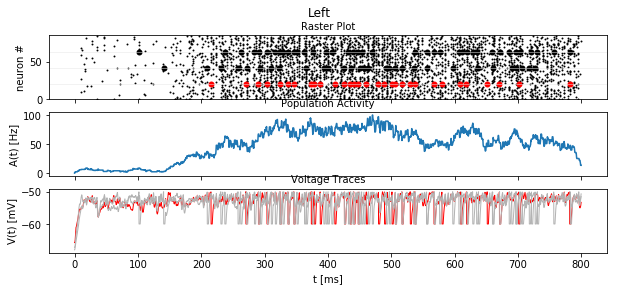

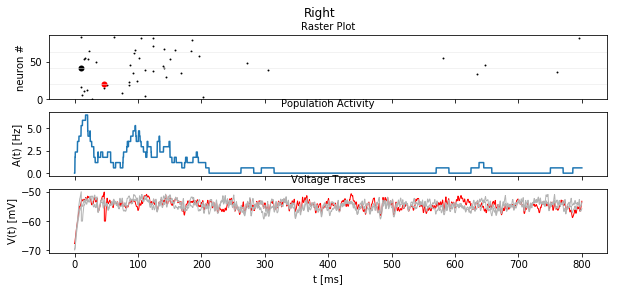

In [2]:
decision_making.getting_started()

Before we can analyse the decision making process and the simulation results, we first need to understand the structure of the network and how we can access the state variables of the respective subpopulations.

<img src="https://neuronaldynamics-exercises.readthedocs.io/en/latest/_images/DecisionMaking_NetworkStructureAll.png" alt="drawing" width="500"/>
*Network structure. The excitatory population is divided into three subpopulations, shown in the next figure.*

<img src="https://neuronaldynamics-exercises.readthedocs.io/en/latest/_images/DecisionMaking_NetworkStructureDetail.png" alt="drawing" width="500"/>

*Structure within the excitatory population. The “Left” and “Right” subpopulations have strong recurrent weights ($w^+>w^0$) and weak projections to the other ($w^−<w^0$). All neurons receive a poisson input from an external source. Additionally, the neurons in the “Left” subpopulation receive poisson input with some rate $\nu_{left}$; the “Right” subpopulation receives a poisson input with a different rate $\nu_{right}$*

### 3.1.1. Question: Understanding Brian2 Monitors

The network shown in the figure above is implemented in Brian2 in the function `competing_populations.decision_making.sim_decision_making_network()`. Each subpopulation is a Brian2 NeuronGroup. Look at the source code of the function `sim_decision_making_network()` to answer the following questions:



**[1+1+1]**

- For each of the four subpopulations, find the variable name of the corresponding NeuronGroup.
- Each NeuronGroup is monitored with a PopulationRateMonitor, a SpikeMonitor, and a StateMonitor. Find the variable names for those monitors. Have a look at the [Brian2](https://brian2.readthedocs.io/en/stable/user/recording.html) documentation if you are not familiar with the concept of monitors.
- Which state variable of the neurons is recorded by the StateMonitor?

**Answer**

- The inhibitory population's NeuronGroup is called `inhib_pop`, the excitatory subpopulations' NeuronGroups are called `excit_pop_A`, `excit_pop_B` and `excit_pop_Z`, receiving stimulus A, stimulus B and non-sensitive, respectively.
- The PopulationRateMonitor is called `rate_monitor` (in particular `rate_monitor_inhib`, `rate_monitor_A`, `rate_monitor_B` and `rate_monitor_Z`), the SpikeMonitor is called `spike_monitor` (`spike_monitor_inhib`, `spike_monitor_A`, `spike_monitor_B` and `spike_monitor_Z`) and the StateMonitor is called `voltage_monitor` (`voltage_monitor_inhib`, `voltage_monitor_A`, `voltage_monitor_B` and `voltage_monitor_Z`).
- The StateMonitor records the voltage of the neurons.

**[2+1]**


- Setting `N_excit=380`how many neurons would be in each excitatory subpopulations?
- To keep the default balance between inhibition and excitation what would be the number of inhibitory neurons?

**Answer**

- In each subpopulation there would be the following number of neurons:

    N_Group_A = N_Excit * f_Subpop_size = 380 * 0.25 = 95

    N_Group_B = N_Group_A = 95

    N_Group_Z = N_Excit - N_Group_A - N_Group_B = 380 - 95 - 95 = 190
    

- To keep the balance, there should be the following amount of inhibitory neurons:

    N_Excit_default : N_Inhib_default = N_Excit : N_Inhib
    
    N_Inhib = (380 * 96) / 384 = 95

For the rest of the miniproject, use `N_Excit=380`, and the found value `N_Inhib`.


### 3.1.2\. Question: Accessing a dictionary to plot the population rates[¶](#question-accessing-a-dictionary-to-plot-the-population-rates "Permalink to this headline")

The monitors are returned in a [Python dictionary](https://docs.python.org/3/tutorial/datastructures.html?highlight=dictionary#dictionaries) providing access to objects by name. Read the [Python documentation](https://docs.python.org/3/tutorial/datastructures.html?highlight=dictionary#dictionaries) and look at the code block below or the function [`competing_populations.decision_making.getting_started()`](https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex.competing_populations.html#neurodynex.competing_populations.decision_making.sim_decision_making_network) to learn how dictionaries are used.

**[6]**

*   Extend the following code block to include plots for all four subpopulations.
*   Run the simulation for 800ms. What are the “typical” population rates of the four populations towards the end of the simulation? (In case the network did not decide, run the simulation again).


simulating 475 neurons. Start: Fri May 17 17:11:40 2019


INFO       width adjusted from 80. ms to 80.1 ms [brian2.monitors.ratemonitor.adjusted_width]


sim end: Fri May 17 17:12:23 2019


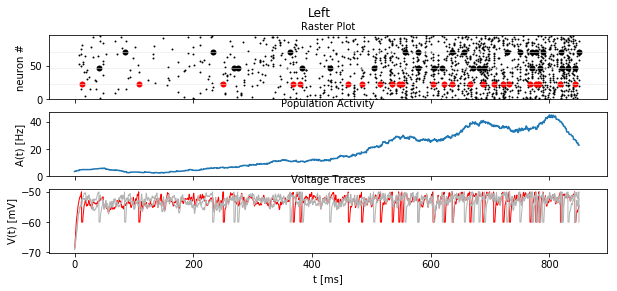

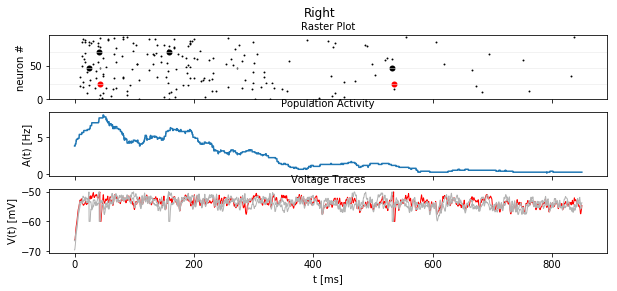

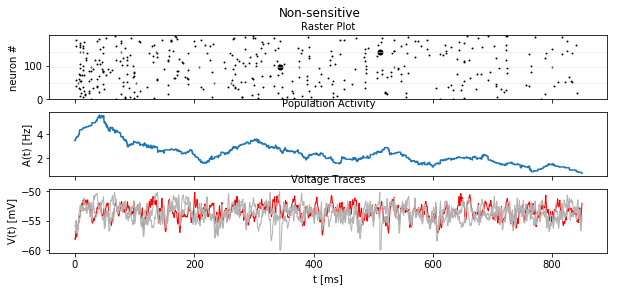

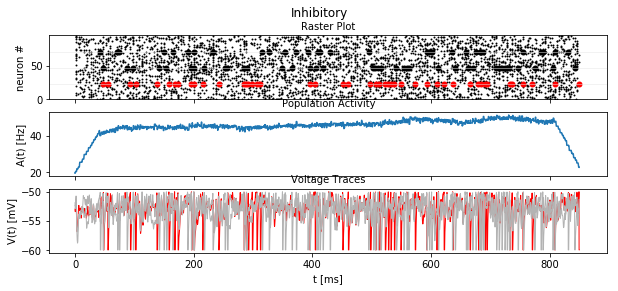

In [3]:
results = decision_making.sim_decision_making_network(N_Excit=380, N_Inhib=95, t_stimulus_start= 50. * b2.ms,
                                                      coherence_level=0.6, max_sim_time=850*b2.ms)
plot_tools.plot_network_activity(results["rate_monitor_A"], results["spike_monitor_A"],
                                 results["voltage_monitor_A"], t_min=0. * b2.ms, avg_window_width=80. * b2.ms,
                                 sup_title="Left")
plot_tools.plot_network_activity(results["rate_monitor_B"], results["spike_monitor_B"],
                                 results["voltage_monitor_B"], t_min=0. * b2.ms, avg_window_width=80. * b2.ms,
                                 sup_title="Right")
plot_tools.plot_network_activity(results["rate_monitor_Z"], results["spike_monitor_Z"],
                                 results["voltage_monitor_Z"], t_min=0. * b2.ms, avg_window_width=80. * b2.ms,
                                 sup_title="Non-sensitive")
plot_tools.plot_network_activity(results["rate_monitor_inhib"], results["spike_monitor_inhib"],
                                 results["voltage_monitor_inhib"], t_min=0. * b2.ms, avg_window_width=80. * b2.ms,
                                 sup_title="Inhibitory")
plt.show()

**Answer**

Towards the end of the simulation the population A (Left choice) presents a high population activity, while the B one (Right choice) is suppressed and has a low population activity; the Inhibitory population is always active and interacts with the excitatory neurons for the entire simulation. The Non-sensitive population, since it does not receive any external input, has very low overall activity, similar to the one of population A.

**[3+2+1]**

*   Without running the simulation again, but by using the same `results` [dictionary](https://docs.python.org/3/tutorial/datastructures.html?highlight=dictionary#dictionaries), plot the 4 population rates on the same graph using 5 different values of `avg_window_width`. 
*   Interpret the effect of a very short and a very long averaging window.
*   Find a value `avg_window_width` for which the population activity plot gives meaningful rates.

Remark: you should use the function [`PopulationRateMonitor.smooth_rate()`](https://brian2.readthedocs.io/en/2.0.1/user/recording.html#recording-population-rates). 

`avg_window_width = 123*b2.ms`

`sr = results["rate_monitor_A"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz`

In [4]:
def population_activity_scatter(avg_window_width, *rms):
    t_min = 0.
    colors = ['red', 'green', 'blue', 'gray']
    pops = ['Left', 'Right', 'Inhib', 'Non-sens']
    for rm, c, p in zip(rms, colors, pops):
        t_max = max(rm.t / b2.ms)
        ts = rm.t / b2.ms
        idx_rate = (ts >= t_min) & (ts <= t_max)
        sr = rm.smooth_rate(window="flat", width=avg_window_width)/b2.Hz
        plt.scatter(ts[idx_rate], sr[idx_rate], s=3, c=c, label=p)
    
    plt.legend(markerscale=3)
    plt.ylabel("A(t) [Hz]")
    plt.title("Population Activity", fontsize=10)
    plt.show()

INFO       width adjusted from 10. ms to 10.1 ms [brian2.monitors.ratemonitor.adjusted_width]


Averaging window width: 10


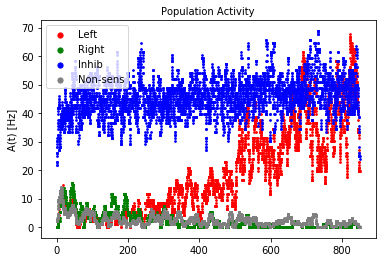

Averaging window width: 20


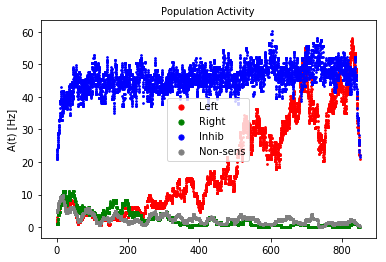

INFO       width adjusted from 50. ms to 50.1 ms [brian2.monitors.ratemonitor.adjusted_width]


Averaging window width: 50


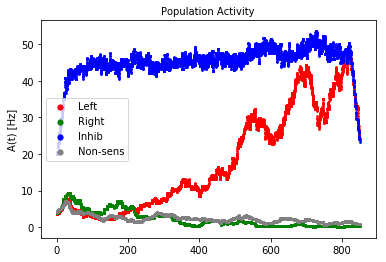

Averaging window width: 80


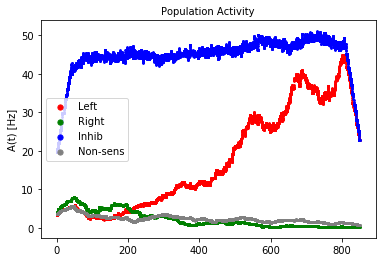

INFO       width adjusted from 150. ms to 149.9 ms [brian2.monitors.ratemonitor.adjusted_width]


Averaging window width: 150


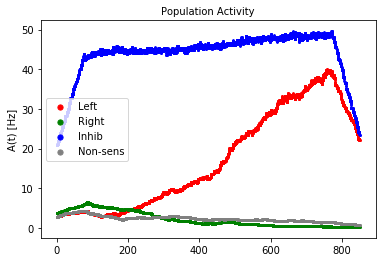

In [5]:
awws = [10, 20, 50, 80, 150]
for aww in awws:
    print("Averaging window width: %d"% aww)
    population_activity_scatter(aww*b2.ms, results["rate_monitor_A"], results["rate_monitor_B"],
                                results["rate_monitor_inhib"], results["rate_monitor_Z"])

**Answer**

- A very short averaging window allows to show more in details the spikes of the neurons of the different populations, thus it is very difficult to infer the spiking frequency. Increasing the averaging window, one can notice that the functions become smoother and easily readable.

- Since we usually run simulations for around $800$ ms, we choose an averaging window of $80$ ms, based on the results of the above plots.

In [6]:
aww = 80 # [ms] avg_window_width


## 3.2. Exercise: Stimulating the decision making circuit

The input stimulus is implemented by two inhomogenous Poisson processes: The subpopulation “Left” and “Right” receive input from two different PoissonGroups (see Figure “Network Structure”). The input has a `coherence level c` and is noisy. We have implemented this in the following way: every 30ms, the firing rates $\nu_{left}$ and  $\nu_{right}$  of each of the two PoissonGroups are drawn from a normal distribution:


$\nu_{left}\sim\mathcal{N}(\mu_{left},\sigma^2)$

$\nu_{right}\sim\mathcal{N}(\mu_{right},\sigma^2)$

$\mu_{left}=\mu_0*(0.5+0.5c)$

$\mu_{right}=\mu_0*(0.5-0.5c)$

$c\in[-1,+1]$

The coherence level $c$, the maximum mean $\mu_0$ and the standard deviation $\sigma$ are parameters of `sim_decision_making_network()`.

## 3.2.1. Question: Coherence Level

**[1+1]**

- From the equation above, express the difference $\mu_{left}−\mu_{right}$ in terms of $\mu_0$ and $c$.

- Find the distribution of the difference $\nu_{left}−\nu_{right}$. Hint: the difference of two Gaussian distributions is another Gaussian distribution.


Now look at the documentation of the function [`sim_decision_making_network()`](https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex.competing_populations.html#neurodynex.competing_populations.decision_making.sim_decision_making_network) and find the default values of μ0 and σ. Using those values, answer the following questions:

**[1+1]**

- What are the mean firing rates (in Hz) $\mu_{left}$ and $\mu_{right}$ for the coherence level c= +0.2?
- For c= +0.2, how does the difference $\mu_{left}$ and $\mu_{right}$ compare to the variance of $\nu_{left}$ and $\nu_{right}$.

**Answer**

- $\mu_{left}−\mu_{right} = \mu_0 c$.

- Assuming independence between $\nu_{left}$ and $\nu_{right}$, the distribution of the difference is

    $\nu_{left}−\nu_{right} \sim \mathcal{N}(\mu_{left}-\mu_{right}, 2\sigma^2) = \mathcal{N}(\mu_0 c, 2\sigma^2)$.
    
    
- Default values in the function `sim_decision_making_network()` are $\mu_0 = 160$ Hz and standard deviation $\sigma = 20$ Hz.

- Mean firing rates $\mu_{left}$ and $\mu_{right}$ for the coherence level $c = 0.2$ are

    $\mu_{left} = 96$ Hz
    
    $\mu_{right} = 64$ Hz.
    
    
- For the coherence level $c = 0.2$, the difference between the two means is $\mu_{left} - \mu_{right} = \mu_0 c = 32$ Hz and the variance is $\sigma^2 = 400$, which corresponds to a standard deviation of $20$ Hz. The two normal distributions intersect at $80$ Hz (at distance $16$ Hz from the two means, which is smaller than the standard deviation). This means that almost $20\%$ of the time sampling from one distribution is the same as sampling from the other one, for both left and right firing rates. This can lead to wrong decision makings, in this particular case the wrong decision would be right insted of left.

## 3.2.2. Question: Input stimuli with different coherence levels

**[2+1+1]**

Run a few simulations with `c=-0.6` and `c=+0.1`. Plot the network activity.

- Does the network always make the correct decision?
- Look at the population rates and estimate roughly how long it takes the network to make a decision.


In [7]:
c = -0.6
results = []
for i in range(5):
    r = decision_making.sim_decision_making_network(N_Excit=380, N_Inhib=94, t_stimulus_start= 0. * b2.ms,
                                                          coherence_level=c, max_sim_time=800.*b2.ms)
    results.append(r)

simulating 474 neurons. Start: Fri May 17 17:25:06 2019
sim end: Fri May 17 17:25:46 2019
simulating 474 neurons. Start: Fri May 17 17:25:46 2019
sim end: Fri May 17 17:26:26 2019
simulating 474 neurons. Start: Fri May 17 17:26:26 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:27:11 2019
simulating 474 neurons. Start: Fri May 17 17:27:11 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:27:59 2019
simulating 474 neurons. Start: Fri May 17 17:27:59 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:28:43 2019


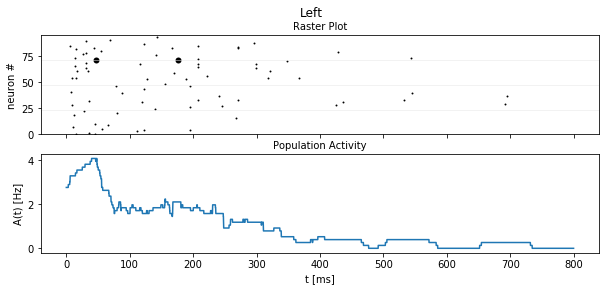

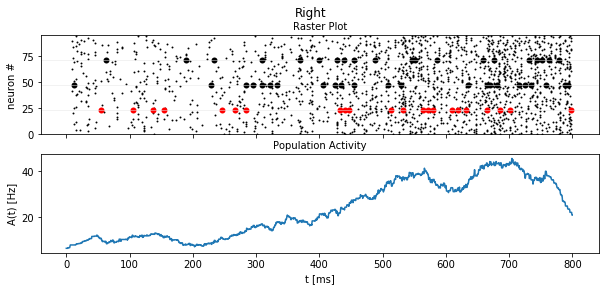

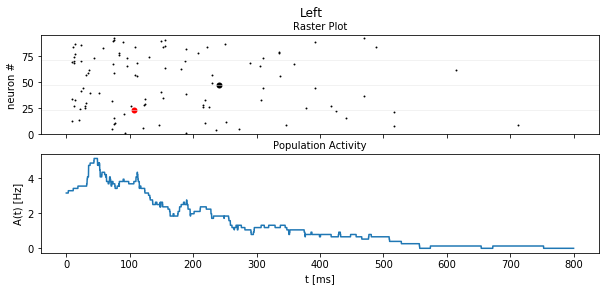

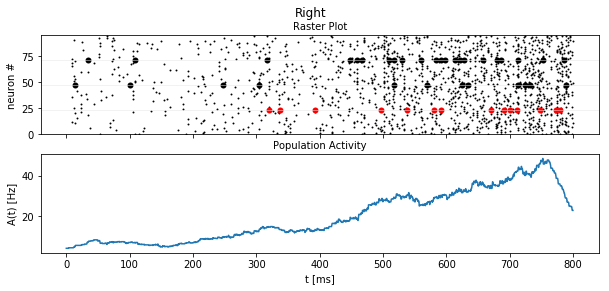

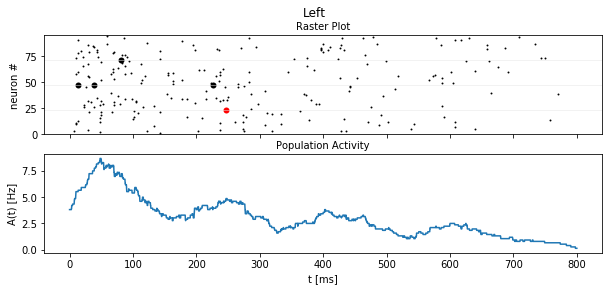

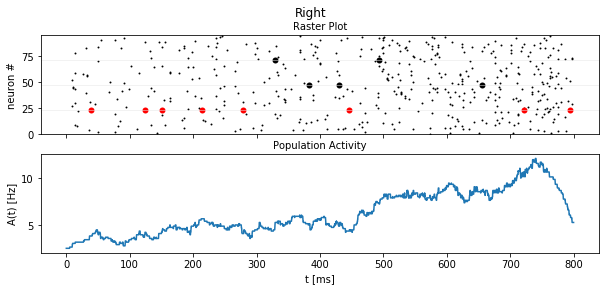

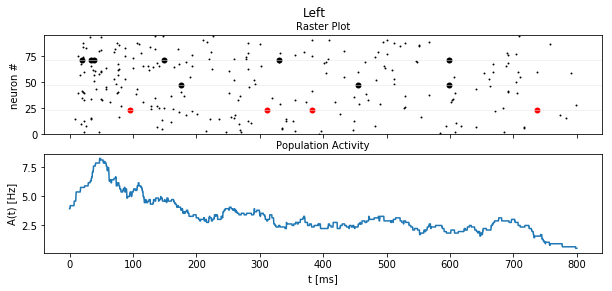

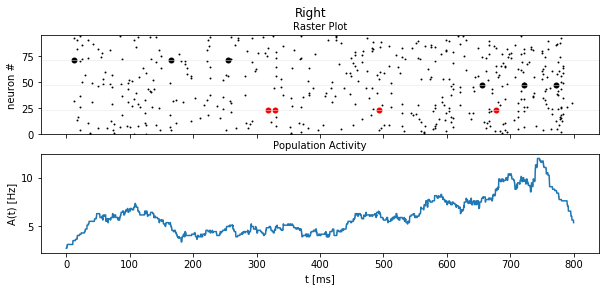

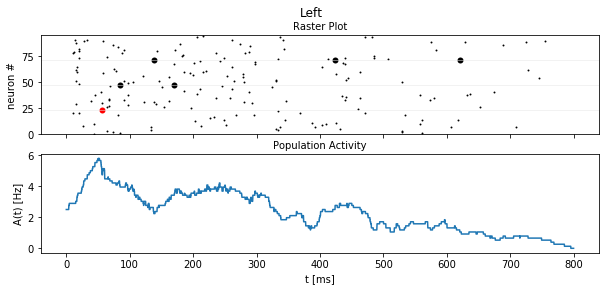

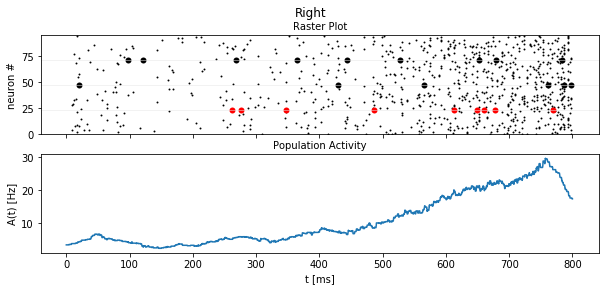

In [8]:
for r in results:
    plot_tools.plot_network_activity(r["rate_monitor_A"], r["spike_monitor_A"],
                                     t_min=0. * b2.ms, avg_window_width=aww * b2.ms,
                                     sup_title="Left")
    plot_tools.plot_network_activity(r["rate_monitor_B"], r["spike_monitor_B"],
                                     t_min=0. * b2.ms, avg_window_width=aww * b2.ms,
                                     sup_title="Right")
    plt.show()

In [9]:
c = 0.1
results = []
for i in range(5):
    r = decision_making.sim_decision_making_network(N_Excit=380, N_Inhib=94, t_stimulus_start= 0. * b2.ms,
                                                    coherence_level=c, max_sim_time=800.*b2.ms)
    results.append(r)

simulating 474 neurons. Start: Fri May 17 17:28:47 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:29:31 2019
simulating 474 neurons. Start: Fri May 17 17:29:31 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:30:14 2019
simulating 474 neurons. Start: Fri May 17 17:30:14 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:30:58 2019
simulating 474 neurons. Start: Fri May 17 17:30:58 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
si

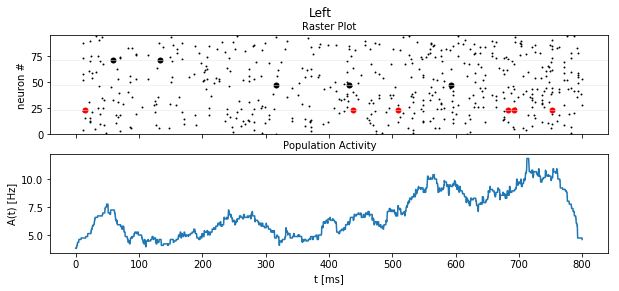

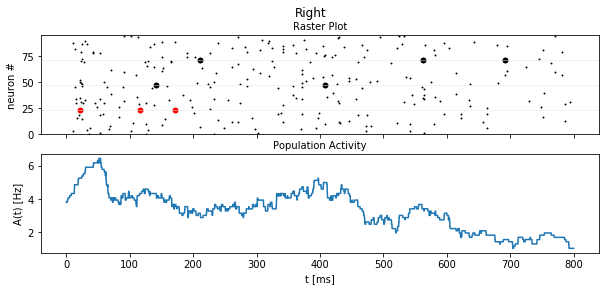

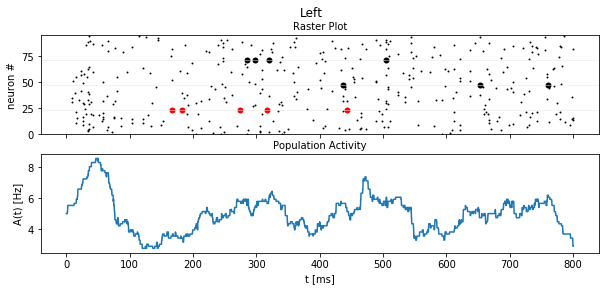

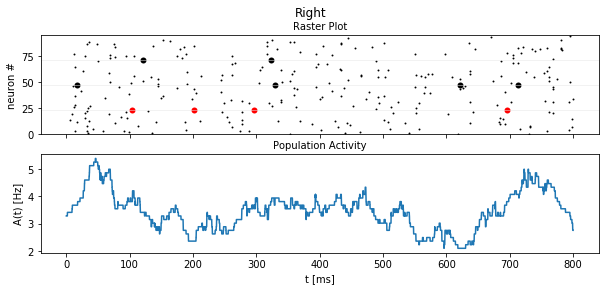

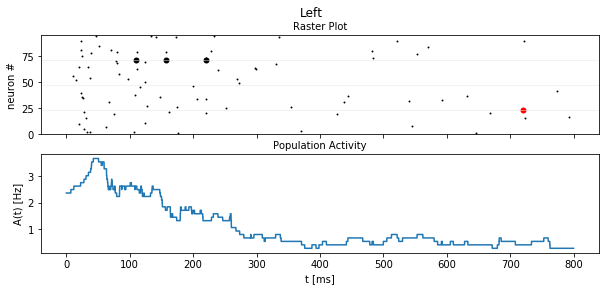

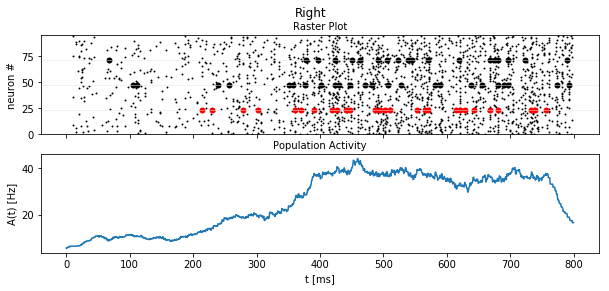

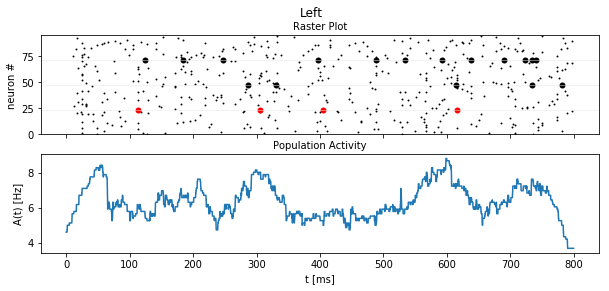

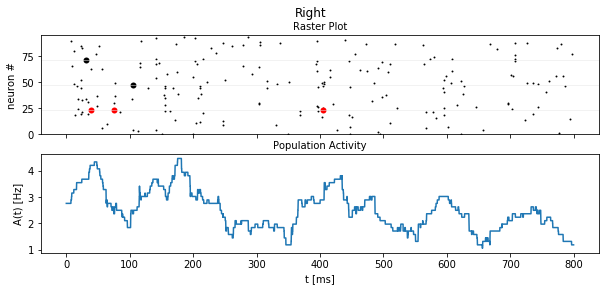

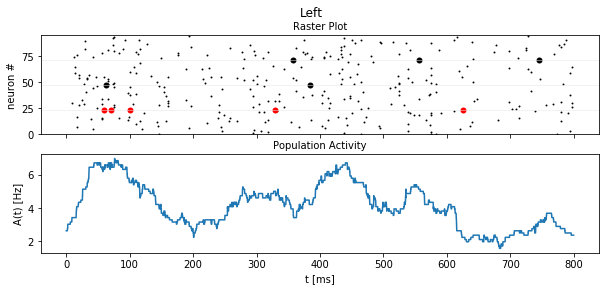

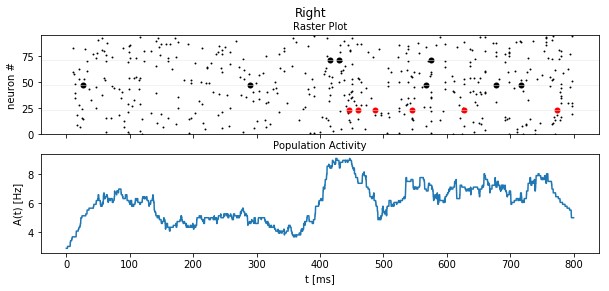

In [10]:
for r in results:
    plot_tools.plot_network_activity(r["rate_monitor_A"], r["spike_monitor_A"],
                                     t_min=0. * b2.ms, avg_window_width=aww * b2.ms,
                                     sup_title="Left")
    plot_tools.plot_network_activity(r["rate_monitor_B"], r["spike_monitor_B"],
                                     t_min=0. * b2.ms, avg_window_width=aww * b2.ms,
                                     sup_title="Right")
    plt.show()

**Answer**

- For $c = -0.6$ the network always makes the correct decision (right), because the mean of the $\nu_{right}$ distribution is much bigger than the other ($\mu_{right} = 128$ Hz compared to $\mu_{left} = 32$ Hz). On the other hand, for $c = 0.1$, the network sometimes makes the wrong decision (right) and sometimes, even for simulation times of $1000$ milliseconds, does not make a decision at all. This is because the firing rates of the stimuli are much closer to each others.


- In order to estimate when the network makes a decision, we first need to define a firing threshold (in Hz) after which we consider that the network has made a final decision. As can be seen from the plots of the population activities, during the first couple hundreds milliseconds, both left and right pupolations have the same firing rates. Thus, we decide to ignore the threshold crossing during this first part of the simulation (see References [1], Parameter values, p. 1317). Moreover, It is clear that when the network makes a decision, the firing rate of the two populations are sharply distinct. Since we want to identify a constant state in both networks, we use an averaging window width of $80$ milliseconds, which nicely smooth the population activities. Then, we search for a time interval in which one population is above $25$ Hz. For a coherence level of $-0.6$, the network takes a decision after around $400$ milliseconds, while for $0.1$ it takes around $700$ milliseconds.

## 3.3. Exercise: Decision Space

We can visualize the dynamics of the decision making process by plotting the activities of the two subpopulations “Left” / “Right” in a phase plane (see figure at the top of this page). Such a phase plane of competing states is also known as the _Decision Space_. A discussion of the decision making process in the decision space is out of the scope of this exercise but we refer to Reference [1]



### 3.3.1 Question: Plotting the Decision Space

**[5+2]**

*   Write a function that takes two [RateMonitors](http://brian2.readthedocs.io/en/2.0.1/user/recording.html#recording-population-rates) and plots the _Decision Space_.
*   Add a parameter `avg_window_width` to your function (same semantics as in the exercise above). Run a few simulations and plot the phase plane for different values of `avg_window_width`. Use `c=0.3`.


In [11]:
def plot_decision_space(rmL, rmR, avg_window_width):
    """
        Plots the decision space for the populations 'Left' and 'Right', given the rate monitors.
        
        Inputs
        ------
        rmL: Rate monitor for the population 'Left'
        rmR: Rate monitor for the population 'Right'
        avg_window_width: Milliseconds, window size when smoothing the firing rates
    """
    
    # defining the time scale
    t_max = max(rmL.t / b2.ms)
    # adjustment, to discard the decreasing activity of the winning population at the end of the simulation
    t_max -= 150
    t_min = 0
    ts = rmL.t / b2.ms
    idx_rate = (ts >= t_min) & (ts <= t_max)
    
    # smoothing the firing rates
    smL = rmL.smooth_rate(window="flat", width=avg_window_width)/b2.Hz
    smR = rmR.smooth_rate(window="flat", width=avg_window_width)/b2.Hz
    
    # defining plot dimensions
    t1 = max(smL)
    t2 = max(smR)
    top = max(t1, t2)+5
    
    # plotting
    plt.scatter(smR[idx_rate], smL[idx_rate], s=10, c=ts[idx_rate])
    plt.colorbar(label="Time [milliseconds]")
    plt.clim(t_min, t_max)
    plt.xlim(0, top)
    plt.ylim(0, top)
    plt.title("Decision space")
    plt.xlabel("Population rate 'Right' [Hz]")
    plt.ylabel("Population rate 'Left' [Hz]")
    plt.show()

In [12]:
c = 0.3
results = []
for i in range(5):
    r = decision_making.sim_decision_making_network(N_Excit=380, N_Inhib=94, t_stimulus_start= 0. * b2.ms,
                                                    coherence_level=c, max_sim_time=1000.*b2.ms)
    results.append(r)

simulating 474 neurons. Start: Fri May 17 17:34:56 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:35:50 2019
simulating 474 neurons. Start: Fri May 17 17:35:50 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:36:44 2019
simulating 474 neurons. Start: Fri May 17 17:36:44 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:37:38 2019
simulating 474 neurons. Start: Fri May 17 17:37:38 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:38:31 2019
simulating

Averaging window width: 10


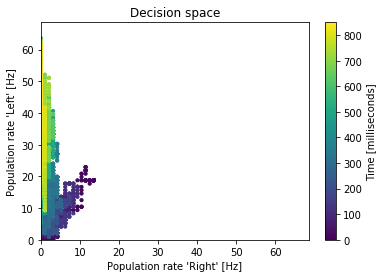

Averaging window width: 30


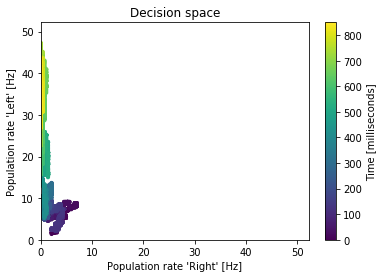

Averaging window width: 80


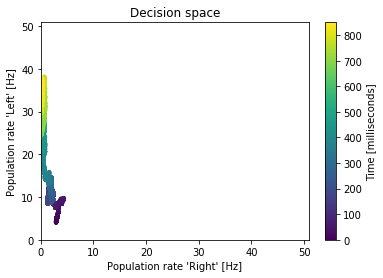

Averaging window width: 150


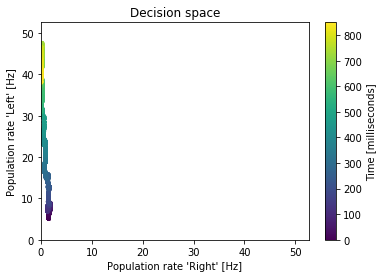

Averaging window width: 250


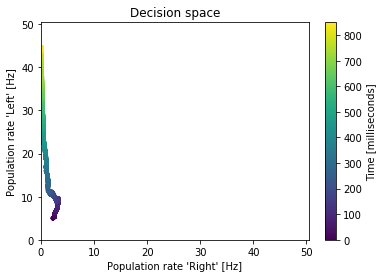

In [14]:
awws = [10, 30, 80, 150, 250]
for i, r in enumerate(results):
    print("Averaging window width: %d"% awws[i])
    plot_decision_space(r["rate_monitor_A"], r["rate_monitor_B"], awws[i] * b2.ms)

**[2]**

*   We can use a rate threshold as a decision criterion: We say the network has made a decision if one of the (smoothed) rates crosses a threshold. What are appropriate values for `avg_window_width` and `rate` to detect a decision from the two rates?

**Answer**

As already stated in <b>3.2.2</b>, when the network makes a decision, the firing rate of the two populations are sharply distinct. Since we want to identify a constant state in both networks, we use an averaging window width `avg_window_width` of $80$ milliseconds, which nicely smooth the population activities. Then, we search for a time interval in which one population is above $25$ Hz. So we can say that `rate` is $25$ Hz.

### 3.3.2 Question: Implementing a decision criterion

**[4]**

*   Using your insights from the previous questions, implement a function **get_decision_time** that takes two [RateMonitors](http://brian2.readthedocs.io/en/2.0.1/user/recording.html#recording-population-rates), a `avg_window_width` and a `rate_threshold`. The function should return a tuple (decision_time_left, decision_time_right). The decision time is the time index when some decision boundary is crossed. Possible return values are (1234.5ms, 0ms) for decision “Left”, (0ms, 987.6ms) for decision “Right” and (0ms, 0ms) for the case when no decision is made within the simulation time. A return value like (123ms, 456ms) is an error and occurs if your function is called with inappropriate values for `avg_window_width` and `rate_threshold` and must be considered as such in your code. 

The following code fragments could be useful:

`smoothed_rates_A = rate_monitor_A.smooth_rate(window="flat", width=avg_window_width) / b2.Hz
idx_A = numpy.argmax(smoothed_rates_A > rate_threshold/b2.Hz)
t_A = idx_A * b2.defaultclock.dt`

Run a few simulations to test your function.

In [15]:
def get_decision_time(rmL, rmR, avg_window_width, rate_threshold):
    """
        Return the decision times for the populations 'Left' and 'Right', given the rate monitors.
        
        Inputs
        ------
        rmL: Rate monitor for the population 'Left'
        rmR: Rate monitor for the population 'Right'
        avg_window_width: Milliseonds, window size when smoothing the firing rates
        rate_threshold: threshold after which the network has made a decision
        
        Outputs
        -------
        (decision_time_left, decision_time_right): Milliseconda, time after which a decision is made.
                                                   at least one of the two must be 0.
    """
    
    t_min = 1500 # 150 ms, see Reference [1], Parameter values, p. 1317
    
    srL = rmL.smooth_rate(window="flat", width=avg_window_width)/b2.Hz
    srR = rmR.smooth_rate(window="flat", width=avg_window_width)/b2.Hz
        
    srL_above = np.where(srL[t_min:] > rate_threshold)[0]
    srR_above = np.where(srR[t_min:] > rate_threshold)[0]
    
    dtL = (srL_above[0]+t_min)/10 if len(srL_above) > 0 else 0
    dtR = (srR_above[0]+t_min)/10 if len(srR_above) > 0 else 0
    
    return (dtL, dtR)

In [18]:
aww = 80
cs = np.random.uniform(-1, 1, 5)
decision_times = []
for c in cs:
    r = decision_making.sim_decision_making_network(N_Excit=380, N_Inhib=94, t_stimulus_start= 0. * b2.ms,
                                                    coherence_level=c, max_sim_time=800.*b2.ms)
    dt = get_decision_time(r["rate_monitor_A"], r["rate_monitor_B"], aww*b2.ms, 25)
    decision_times.append(dt)

simulating 474 neurons. Start: Fri May 17 17:46:46 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:47:30 2019
simulating 474 neurons. Start: Fri May 17 17:47:30 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:48:16 2019
simulating 474 neurons. Start: Fri May 17 17:48:16 2019
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:49:01 2019
simulating 474 neurons. Start: Fri May 17 17:49:01 2019
Missing compiler_cxx fix for MSVCCompiler
sim end: Fri May 17 17:49:43 2019
simulating 474 neurons. Start: Fri May 17 17:49:43 2019
Missing compiler_cxx fix for MSVCCompi

In [19]:
for i, dt in enumerate(decision_times):
    print("c = {}\tdecision times = {}".format(cs[i], dt))

c = 0.0412959001109	decision times = (685, 0)
c = 0.429779256437	decision times = (0, 0)
c = -0.912994952027	decision times = (0, 512)
c = -0.745386589972	decision times = (0, 402)
c = 0.422445742961	decision times = (355, 0)


**[1]**

How do the percentage of correct answer evolve with respect to `c`.

**Answer**

Let us consider $c \ge 0$. Increasing $c$ makes $\mu_{left}$ bigger and $\mu_{right}$ smaller. The two gaussian distributions for the spike frequencies pull apart. Thus, the percentage of correct answer increases as $c$ grows.

Viceversa, for $c \le 0$, the percentage of correct answer decreases as $c$ grows.

# 3.5 Winner-take-all in artificial Neural network

Winner-take-all is a computational models of neural networks by which neurons in a layer compete with each other for activation.  

In the classical form, only the neuron with the highest activation stays active while all other neurons are shut down; however, other variations allow more than one neuron to be active. It may be link to a decision making task as the decision is defined by the winner neuron.

Consider a network of formal neurons described by activities
\begin{equation}
  A_i= g(h_i) = \left\{
    \begin{array}{ll}
    0 & \mbox{ for } h_i<1 \\
    h_i -1& \mbox{ for } 1<h_i<2\\ 
    1& \mbox{ for } h_i>2\\ 
    \end{array}
  \right. .
\end{equation}
for $i=1,...,N$, where $N$ is the number of neurons.
The input potential $h_i$ evolves with the following update rule: 

$\tau\frac{dh_i}{dt}= f(h) = -h_i + w_0g(h_i) - \alpha\sum_{j \neq i} g(h_j) + h_{ext,i}$. (1)

where $w_0$ and $\alpha$ are parameters greater than 0. For $t \leq 0$ the external input vanishes and all the neurons are at their resting potential $h_i=0$. For $t > 0$ we have $h_{ext,i} = 1 + (0.5)^i$

**[1+1]**

- what is the intrepretation of $w_0$ and $\alpha$

**Answer**

w0 is the weight of the interaction within the neuron, which is always positive, but present only when the input potential of the neuron is greater than 1. 

Alpha is the weight of the interactions between the different neurons. In this case each neuron is inhibited by all the other neurons (if their input potential is greater than 1).

## 3.5.1 Implementation of simple winner-take-all

**[2+3]**

- Implement the function $g(h_i)$ which takes in argument $h_i$. 

- Implement the update rule in a simple Euler fashion i.e. $h_i(t+\Delta t) = h_i(t) + \eta f(h(t))$. 

We impose here $\eta = \Delta t / \tau = 0.01$.

**Answer**

In [20]:
## gain function ##
def g(h):
    ## takes a vector returns a vector of all neurons ##
    g_h = np.copy(h) - 1
    g_h[g_h < 0] = 0
    g_h[g_h > 1] = 1
    return  g_h  

## update rule for the potentials ##
def update_rule(h, eta, w0, alpha, h_ext):
    ## takes a vector returns a vector of all neurons ##
    hh = np.copy(h)
    g_h = g(h)
    summ = np.empty(g_h.shape, dtype=float)
    for i in range(len(g_h)):
        summ[i] = np.sum(g_h[0:i]) + np.sum(g_h[i+1:])
    
    return hh + eta * (-hh + w0*g_h - alpha*summ + h_ext)

**[3]**
- Now run a simulation for a small network of `10 neurons` for $500$ time steps, with $w_0=2$ and $\alpha=1$. and plot the resulting activities. Comment on what you observe.


In [27]:
def simulate_network(N_neuron, N_iter, alpha, w0, eta, h_init, h_ext, verbose=False, plot_pot=False, plot_act=True):
    h = np.copy(h_init)
    dic_evolution = {}
    dic_evolution['iterations'] = []
    dic_evolution['activities'] = []
    dic_evolution['potentials'] = []
    for i in range(N_iter):

        h_next = update_rule(h, eta, w0, alpha, h_ext)

        dic_evolution['iterations'].append(i)
        dic_evolution['potentials'].append(h_next)
        dic_evolution['activities'].append(g(h_next)) ## add the activity at time t to the list ##
        h = h_next

        if (i % 100 == 0 and verbose):
            print("Iteration number %d: "%i)
            print(np.around(h_next, decimals=4))

    print("Final iteration: ")
    print(np.around(h_next, decimals=4))
    
    if plot_pot:
        for i in range(N_neuron):
            activities = map(lambda x: x[i], dic_evolution['potentials'])
            plt.plot(dic_evolution['iterations'], activities, label=i+1)
        plt.title("Input potentials")
        plt.xlabel("Iteration")
        plt.ylabel("Voltage")
        plt.grid()
        plt.legend()
        plt.show()
    
    if plot_act:
        for i in range(N_neuron):
            activities = map(lambda x: x[i], dic_evolution['activities'])
            plt.plot(dic_evolution['iterations'], activities, label=i+1)
        plt.title("Population activities")
        plt.xlabel("Iteration")
        plt.ylabel("Activity")
        plt.grid()
        plt.legend()
        plt.show()
    
    return dic_evolution

Iteration number 0: 
[ 0.015   0.0125  0.0112  0.0106  0.0103  0.0102  0.0101  0.01    0.01
  0.01  ]
Iteration number 100: 
[ 0.9564  0.797   0.7173  0.6775  0.6576  0.6476  0.6426  0.6401  0.6389
  0.6383]
Iteration number 200: 
[ 1.7451  0.8622  0.7538  0.6995  0.6724  0.6589  0.6521  0.6487  0.647
  0.6462]
Iteration number 300: 
[ 2.8373  0.4843  0.3653  0.3059  0.2761  0.2613  0.2538  0.2501  0.2482
  0.2473]
Iteration number 400: 
[ 3.2574  0.3357  0.213   0.1516  0.1209  0.1055  0.0979  0.094   0.0921
  0.0911]
Final iteration: 
[ 3.4103  0.2817  0.1575  0.0954  0.0644  0.0489  0.0411  0.0372  0.0353
  0.0343]


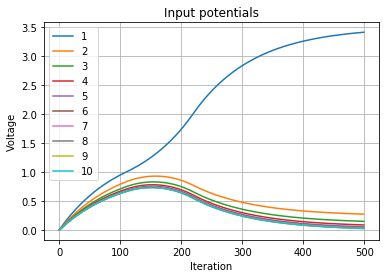

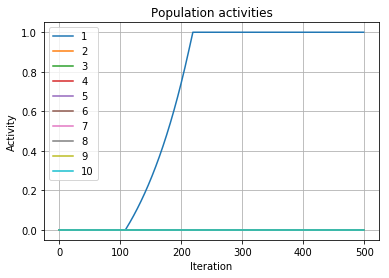

In [28]:
N_neuron = 10
N_iter = 500
alpha = 1
w0 = 2
eta = 0.01
h_ext = 1 + np.logspace(1, N_neuron, num=N_neuron, base=0.5)
h = np.zeros((N_neuron, ), dtype=float) ## initial potential of the neurons (vector) ##
dic_evolution = simulate_network(N_neuron, N_iter, alpha, w0, eta, h, h_ext,
                                 verbose=True, plot_pot=True, plot_act=True)

**Answer**

Only population number $1$ reaches an activity of $1$, while all the others stay at $0$. Thus, there is only one winner, the one with the highest external input potential.

## 3.5.2 Influence of the parameters

**[1+1]**

- What happens if you decrease $\alpha$? (Keep $w_0=2$)

- What happens if you decrease $w_0$? (Keep $\alpha=1$)

justify your answer by the means of plots.

Final iteration: 
[ 3.3545  2.9545  1.4834  0.9518  0.9207  0.9052  0.8974  0.8936  0.8916
  0.8906]


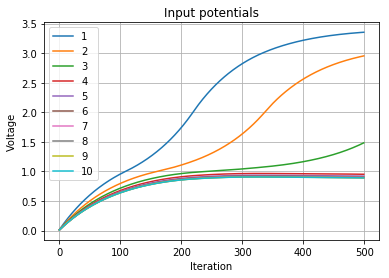

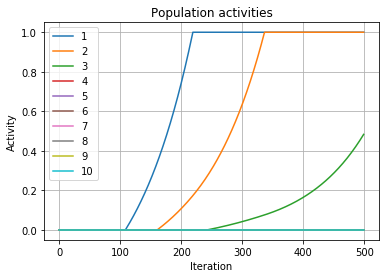

In [30]:
alpha = 0.05
w0 = 2
dic_evolution = simulate_network(N_neuron, N_iter, alpha, w0, eta, h, h_ext, plot_pot=True)

Final iteration: 
[ 1.5393  0.7501  0.626   0.5639  0.5328  0.5173  0.5095  0.5057  0.5037
  0.5027]


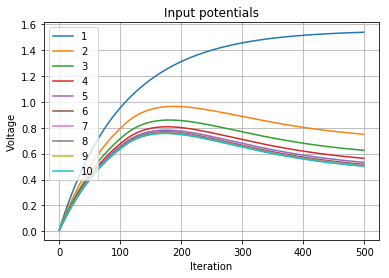

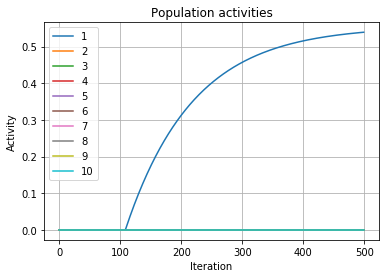

In [31]:
alpha = 1
w0 = 0.1
dic_evolution = simulate_network(N_neuron, N_iter, alpha, w0, eta, h, h_ext, plot_pot=True)

**Answer**

Decreasing $\alpha$ the number of winners increases. This is because the inhibition of the activity of each population is smaller than before. This makes it possible to have more than one winner.

Decreasing $w_0$ does not change the number of winners in the network, but only makes the increase of the activities slower, so that more iterations are necessary to reach a stability condition.

**[2+2]**

Derive sufficient conditions so that the only fixed point is $A_i = \delta_{i,1}$, i.e. only the neuron with the highest external input can be a winner. Write the derived answer and show the critical behaviour.

hints:

- only $h_1$ can be greater than 2 (i.e. $A_1 =1$) all the other must have zero acitivity

**Answer**

In order to study the behaviour of the network when it reaches stability, we have to put the derivative of the input potentials to zero. So

$\quad 0 = -h_i^* + w_0 g(h_i^*) - \alpha \sum_{j\neq i}g(h_j^*)+1+(0.5)^i \quad\quad i = 1, ..., N$

Since $h_{ext, i} = 1 + (0.5)^i$.

We want to have some conditions on the input potentials, in order to obtain the network activity $A_i = g(h_i^*) = \delta_{i,1}$. These conditions are that $h_1^* \ge 2$ and $h_i^* \le 1$ (with $i \neq 1$). This leads us to

$\quad h_1^* = 1.5 + w_0 \ge 2 \\
\quad h_i^* = 1 + (0.5)^i - \alpha \le 1 \quad\quad i\neq 1$

The network activity condition reflects to some conditions on the parameters $w_0$ and $\alpha$. They need to satisfy the following disequations

$\quad w_0 \ge 0.5\\
\quad\alpha \ge 0.25$

Final iteration: 
[ 2.      1.      0.875   0.8125  0.7813  0.7656  0.7578  0.7539  0.752
  0.751 ]


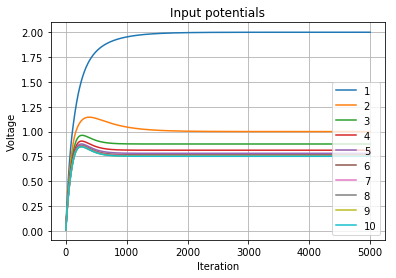

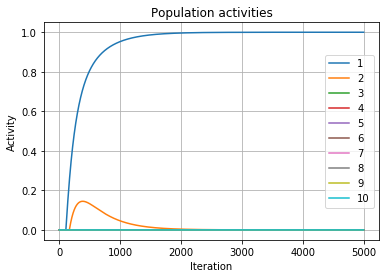

In [33]:
# critical behaviour
N_iter = 5000
alpha = 0.25
w0 = 0.5
dic_evolution = simulate_network(N_neuron, N_iter, alpha, w0, eta, h, h_ext, plot_pot=True)

We can easily see that setting $w_0 = 0.5$ and $\alpha = 0.25$, the input potentials reach stability where $h_1$ is exactly equal to $2$ and $h_i \le 1 (i \neq 1)$. In particular, note that $h_2 = 1$, as expected.

## 3.5.3 Implementation of a K-winners-take-all


**[2+1+1+2]**

By adapting both $w_0$ and $\alpha$ one can update our previous network to obtain a K-winners-take-all neuron, i.e. K neurons will reach an activity of 1.

- Find a necessary condition on $w_0$ as a function of $\alpha$ such that exactly $K$ neurons have activity 1, where the others have all 0 activity.

hint:
- the fixed point of $h_K$ has to be greater than 2 (i.e. $A_K =1$), the K-1 neurons which recive a stronger input have also activity 1 and all the other must have zero acitivity.

**Answer**

Again, let's study the behaviour of the network when it reaches stability

$\quad 0 = -h_i^* + w_0 g(h_i^*) - \alpha \sum_{j\neq i}g(h_j^*)+1+(0.5)^i \quad\quad i = 1, ..., N$

We want to have some conditions on the input potentials, in order to obtain a network where exactly $K$ neurons have activity $1$. The conditions are

$\quad h_i^* = -\alpha (K - 1) + 1 + (0.5)^i + w_0 \ge 2 \quad\quad i = 1, ..., K\\
\quad h_i^* = -\alpha K + 1 + (0.5)^i - \alpha \le 1 \quad\quad i = K+1, ..., N$

The network activity condition reflects on some conditions for the parameters $w_0$ and $\alpha$. The necessary condition on $w_0$ in order to have the expected network activity is

$\quad w_0 \ge 1 - (0.5)^K + \alpha (K - 1)$

We can notice that setting $K = 1$ we obtain again the above condition $w_0 \ge 0.5$.

**Questions**

- One can persuade himself that the following equations are sufficient conditions for alpha. Solve them then **implement the network for K=3 winners**.
\begin{align}
-K\alpha+1+0.5^{K+1} \leq 1 \\
-(K-1)\alpha+1+0.5^K>1 \\
\end{align}
- plot your results, showing the critical behaviour.

**Answer**

Solving for $\alpha$

$\quad\frac{(0.5)^{K+1}}{K} \le \alpha < \frac{0.5^K}{K-1}$

We now implement a 3-winners-take-all neural network. The conditions to be respected are

$\quad 0.02083 \le \alpha < 0.0625\\
\quad w_0 \ge 0.875 + 2\alpha$

Final iteration: 
[ 3.4196  3.1687  3.036   0.9427  0.9114  0.8958  0.888   0.8841  0.8821
  0.8812]


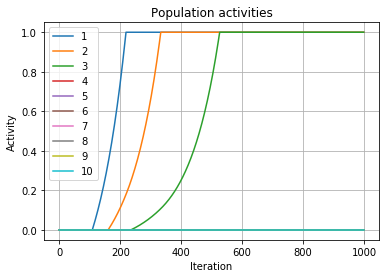

In [36]:
# 3-winners-take-all neural network
N_iter = 1000
alpha = 0.04
w0 = 2
dic_evolution = simulate_network(N_neuron, N_iter, alpha, w0, eta, h, h_ext)

Final iteration: 
[ 2.4297  2.1797  1.1254  0.9297  0.8984  0.8828  0.875   0.8711  0.8691
  0.8681]


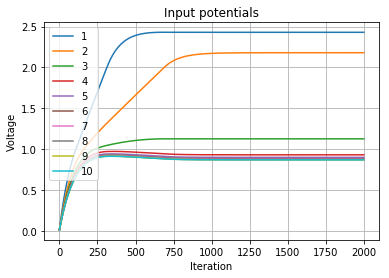

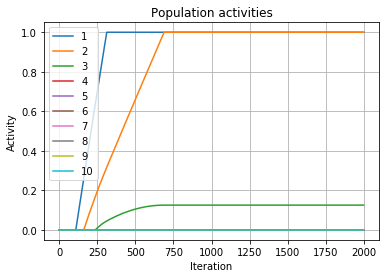

In [38]:
# critical behaviour
N_iter = 2000
alpha = 0.0625
w0 = 1
dic_evolution = simulate_network(N_neuron, N_iter, alpha, w0, eta, h, h_ext, plot_pot=True)

## 3.5.4 stochastic input, winners-take-all

In biological neural network we often consider noisy input coming from background activity. In this exercise we want you to observe the influence of the noise in the winner-take-all process. 

To do so consider $w_0=2$ and $\alpha=2$ and define the external input as $h_{ext,k}= 1 + 0.5^k +\xi(t)$, where $\xi(t)$  is a white noise of standard deviation 1.

**[2+1]**

- implement the white noise and run a simulation, what do you observe? Compute the probability of the neuron 1 to win

**Answer**

Final iteration: 
[ 4.0537 -0.1197 -0.2448 -0.3068 -0.3379 -0.3534 -0.3612 -0.3651 -0.367
 -0.368 ]


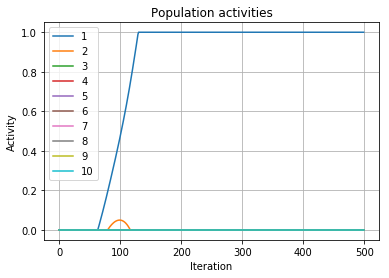

Final iteration: 
[ 3.2824  2.35   -1.0353 -1.0987 -1.13   -1.1457 -1.1535 -1.1573 -1.1593
 -1.1603]


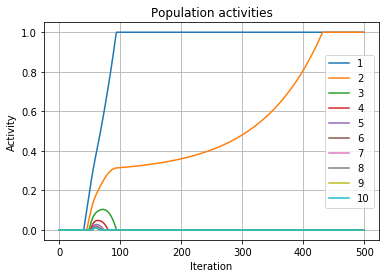

Final iteration: 
[-0.5267 -0.775  -0.8992 -0.9613 -0.9923 -1.0078 -1.0156 -1.0195 -1.0214
 -1.0224]


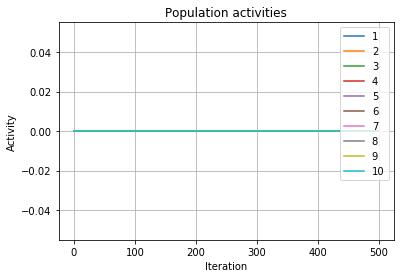

Final iteration: 
[ 3.1405 -0.8021 -0.9263 -0.9884 -1.0194 -1.035  -1.0427 -1.0466 -1.0486
 -1.0495]


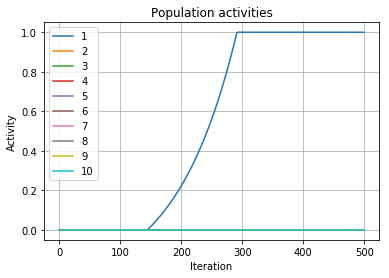

Final iteration: 
[ 4.1627 -0.0143 -0.1403 -0.2024 -0.2335 -0.249  -0.2568 -0.2606 -0.2626
 -0.2635]


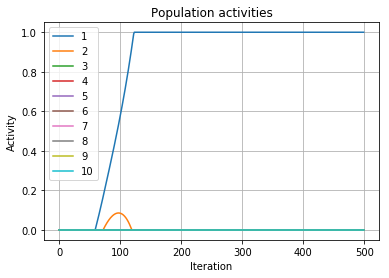

In [39]:
N_iter = 500
alpha = 2
w0 = 2
for i in range(5):
    noise = np.random.normal()
    h_ext = 1 + np.logspace(1, N_neuron, num=N_neuron, base=0.5) + noise
    dic_evolution = simulate_network(N_neuron, N_iter, alpha, w0, eta, h, h_ext, plot_act=True)

We observe that adding white noise to the external input potential, the winner of the neural network is not sure anymore. Sometimes it can also happen that more than one neuron reach activity $1$.

In [ ]:
noises = np.linspace(-1, 2.5, 100)
r = 0
results = []
for n in noises:
    h_ext = 1 + np.logspace(1, N_neuron, num=N_neuron, base=0.5) + n
    dic_evolution = simulate_network(N_neuron, N_iter, alpha, w0, eta, h, h_ext, plot_act=False)
    a = dic_evolution['activities']
    if (np.sum(a[len(a)-1] >= 1) > r):
        results.append(n)
        r += 1

In order to compute the probability of the first neuron to win, we compute empirically when the first neuron wins, adding different values of the "noise" by hand. The following results are for the level of noise when the network switch from "nobody wins" to "first wins" and from "first wins" to "two win".

In [ ]:
print(results)

Thus, we understand that in order to have just one winner, the noise must follow the disequations

$\quad -0.399 \le \xi(t) \le 1.475$

The probability is then easy to calculate as

$\quad P(-0.399 \le \xi(t) \le 1.475) = \int_{-0.399}^{1.475} N(0, 1) = 0.585 = 58.5 \%$

**[3]**

- Now consider the external input $h_{ext,k}= 1 + 0.9^k +\xi(t)$. Run a few simulations to estimate the probability of neuron 1 to win. Comment on the differences you observe [max 5 lines]

**Answer**

Following the same procedure

In [ ]:
noises = np.linspace(-1, 2.5, 100)
r = 0
results = []
for n in noises:
    h_ext = 1 + np.logspace(1, N_neuron, num=N_neuron, base=0.9) + n
    dic_evolution = simulate_network(N_neuron, N_iter, alpha, w0, eta, h, h_ext, plot_act=False)
    a = dic_evolution['activities']
    if (np.sum(a[len(a)-1] >= 1) > r):
        results.append(n)
        r += 1

In [ ]:
print(results)

$\quad P(-0.788 \le \xi(t) \le 0.803) =  57.4 \%$